Created on Aug 20, 2019

@author:     Ruchika Verma

Description: Nuclei segmentation using Mask-RCNN and based on Feature Pyramid Network (FPN) and a ResNet 50
             backbone.
            
This model was trained using data from our TMI paper and MoNuSeg challenge
  
Please cite the following paper and our MoNuSeg (https://monuseg.grand-challenge.org/) challenge if you use
this code-


N. Kumar, R. Verma, S. Sharma, S. Bhargava, A. Vahadane and A. Sethi, "A Dataset and a Technique for Generalized Nuclear Segmentation for Computational Pathology," in IEEE Transactions on Medical Imaging, 
vol. 36, no. 7, pp. 1550-1560, July 2017


In [1]:
#Process whole slide images
import openslide
from PIL import Image
import skimage
import imageio
import os,sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from PIL import Image
import scipy
import scipy.ndimage

In [2]:
# Read svs files from the desired path
data_path = '/media/vaid-computer/Ruchika TCGA images/TCGA_FFPES'
files=glob.glob('/media/vaid-computer/Ruchika TCGA images/TCGA_FFPES/*.svs')
len(files)

930

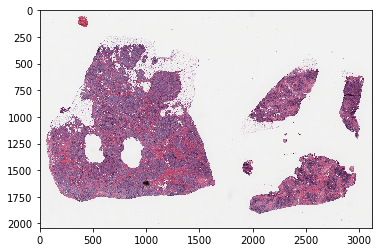

(2041, 3123, 3)


In [3]:
# Reading a single svs file
i = 400

# Read level 3 of an svs image
image_name = files[i]
image_name
img = openslide.OpenSlide(image_name)
level = 3 #For easy visualization
image = np.array(img.read_region((0,0),level,img.level_dimensions[level]).convert('RGB'))
plt.imshow(image)
plt.show()
print(image.shape)

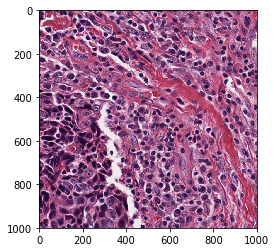

In [4]:
#Extract 1000*1000 patch from a random x,y location
x,y = 1000,700
patch_size = 1000
im_patch = np.array(img.read_region((y*2**(level+2),x*2**(level+2)),0,(patch_size,patch_size)).convert('RGB')) 
plt.imshow(im_patch)

In [5]:
# Import Mask RCNN and load my weights of my trained model
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import nucleus
import tensorflow as tf
config = nucleus.NucleusInferenceConfig()
config.display()
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0
with tf.device(DEVICE):
    nmodel = modellib.MaskRCNN(mode="inference",
                              model_dir=os.getcwd(),
                              config=config)
weights_path = "/media/vaid-computer/Ruchika TCGA images/Nuc_Seg/mask_rcnn_weights.h5"
nmodel.load_weights(weights_path, by_name=True)  


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

Using TensorFlow backend.


Instructions for updating:
Use tf.cast instead.


/home/vaid-computer/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/home/vaid-computer/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]
/home/vaid-computer/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Processing 1 images
image                    shape: (1000, 1000, 3)       min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 2048, 2048, 3)    min:  -51.28000  max:  213.37000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 1047552, 4)       min:   -0.04422  max:    1.01295  float32


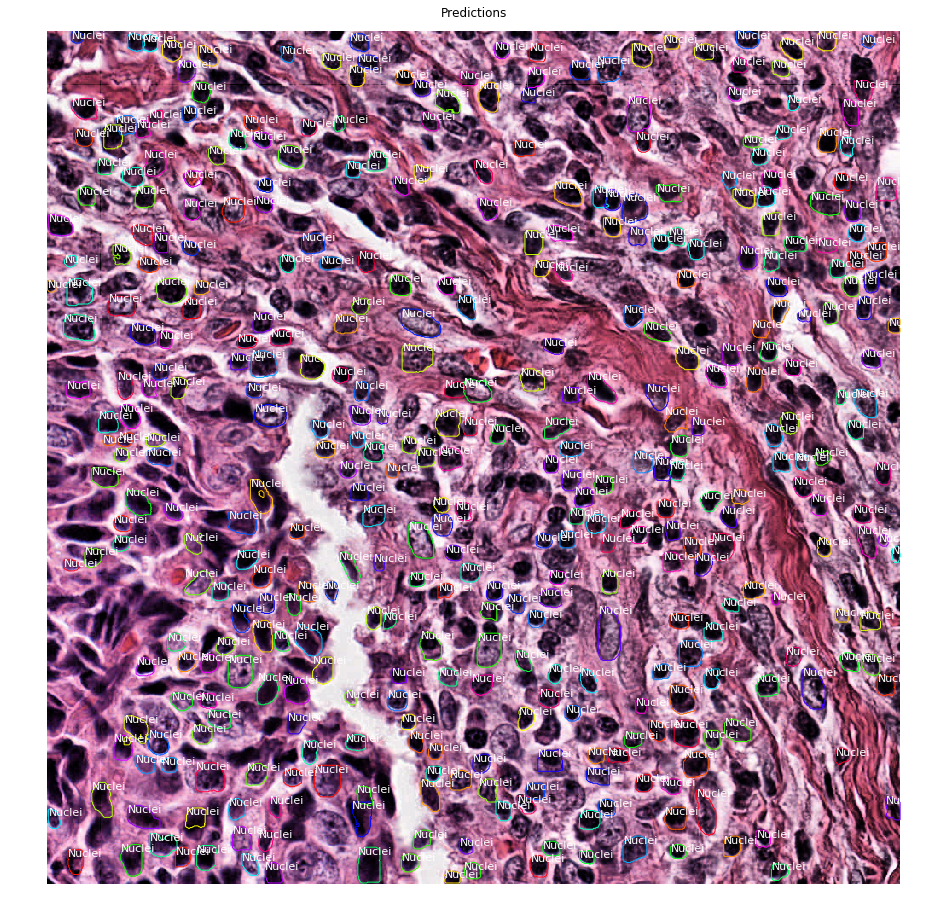

In [6]:
# Run detection and predict nuclei on a patch
im_patch = skimage.exposure.equalize_adapthist(im_patch)
im_patch = skimage.exposure.adjust_log(im_patch)
im_patch = im_patch*255.0
results = nmodel.detect([im_patch], verbose=1)
r = results[0]
visualize.display_instances(im_patch, r['rois'], r['masks'],r['class_ids'],['BG', 'Nuclei'],
                      figsize=(16, 16), ax=None,
                      show_mask=False, show_bbox=False,
                      title="Predictions")  

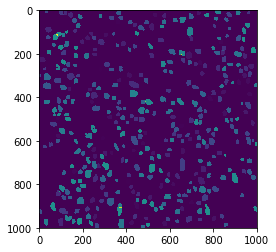

In [7]:
# Generate an n-ary nuclei mask 
individual_nuclei = r['masks']
predicted_nuclei = np.zeros((patch_size,patch_size), dtype = int)
n_nuc = 0
for k in range(individual_nuclei.shape[2]):
    n_nuc += 1
    nuc_mask = r['masks'][:,:,k]
    predicted_nuclei += (n_nuc)*nuc_mask
plt.imshow(predicted_nuclei)
